In [30]:
import yfinance as yfin

import datetime as dt
import sys
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
import pandas as pd
from pandas_datareader import data as pdr 
import seaborn as sns
from pylab import rcParams 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from arch import arch_model
from numpy.linalg import LinAlgError
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
from sklearn.model_selection import TimeSeriesSplit
import warnings


warnings.filterwarnings("ignore")

yfin.pdr_override()

# List of stock symbols
ticker = 'MSFT'

# choose data over 2 years
start_date = '2019-1-1'
end_date = '2021-1-1'

# get the data with 1d interval 
stocks = pdr.get_data_yahoo(ticker, start_date, end_date,interval='1d')
stocks.dropna(inplace=True)


# get log percentage returns
stocks['Return'] = 100 * (stocks['Close'].pct_change())
stocks['Log_Return'] = np.log(stocks['Close']).diff().mul(100) # rescale to faciliate optimization
stocks = stocks.dropna()


[*********************100%***********************]  1 of 1 completed


### Hurst Exponent

The Hurst Exponent is a statistical measure used to classify time series and infer the level of difficulty in predicting and choosing an appropriate model for the series at hand. The Hurst exponent is used as a measure of long-term memory of time series. It relates to the autocorrelations of the time series, and the rate at which these decrease as the lag between pairs of values increases.

- Value near 0.5 indicates a random series.
- Value near 0 indicates a mean reverting series.
- Value near 1 indicates a trending series.

In [54]:
def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)
    
    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    
    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)
    
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

# stats = f'ADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'

stat_test = adfuller(stocks['Return'].dropna())[0:2]
print(f"The test statistic and p-value of ADF test are {stat_test}")
if stat_test[1] < 0.05:
    print("The data is stationary")
else:
    print("The data is not stationary")

hurst_stat = round(hurst(stocks['Return'].values),2)

# print for different case of hurst_stat

print(f"The Hurst Exponent is {hurst_stat}")

The test statistic and p-value of ADF test are (-7.212097179922157, 2.22114354886448e-10)
The data is stationary
The Hurst Exponent is 0.02


The hurst exponent indicates the returns are mean reverting.

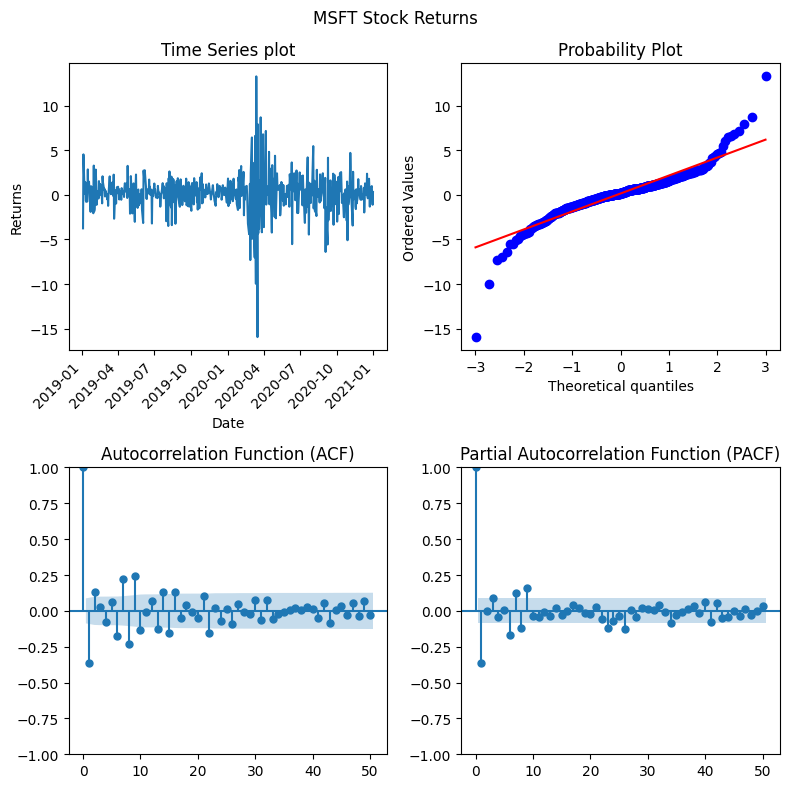

In [62]:
# Plottig the stock returns

def plot_stock_ts(ts,lags,title):

    mosaic = """
    AB
    CD
    """
    fig = plt.figure(figsize=(8,8))
    ax = fig.subplot_mosaic(mosaic)

    ax['A'].plot(ts)
    ax['A'].set_title("Time Series plot")
    ax['A'].set_xlabel("Date")
    ax['A'].set_ylabel("Returns")
    plt.setp(ax['A'].get_xticklabels(), rotation=45, ha="right")
    # Probability plot
    probplot(ts, plot=ax['B'])
    ax['B'].set_title("Probability Plot")

    # ACF plot
    plot_acf(ts, lags=lags, ax=ax['C'])
    ax['C'].set_title("Autocorrelation Function (ACF)")

    # PACF plot
    plot_pacf(ts, lags=lags, ax=ax['D'])
    ax['D'].set_title("Partial Autocorrelation Function (PACF)")

    fig.suptitle(f"{title}")
    plt.tight_layout()
    plt.show()


plot_stock_ts(stocks['Log_Return'], lags=50,title=f'{ticker} Stock Returns')


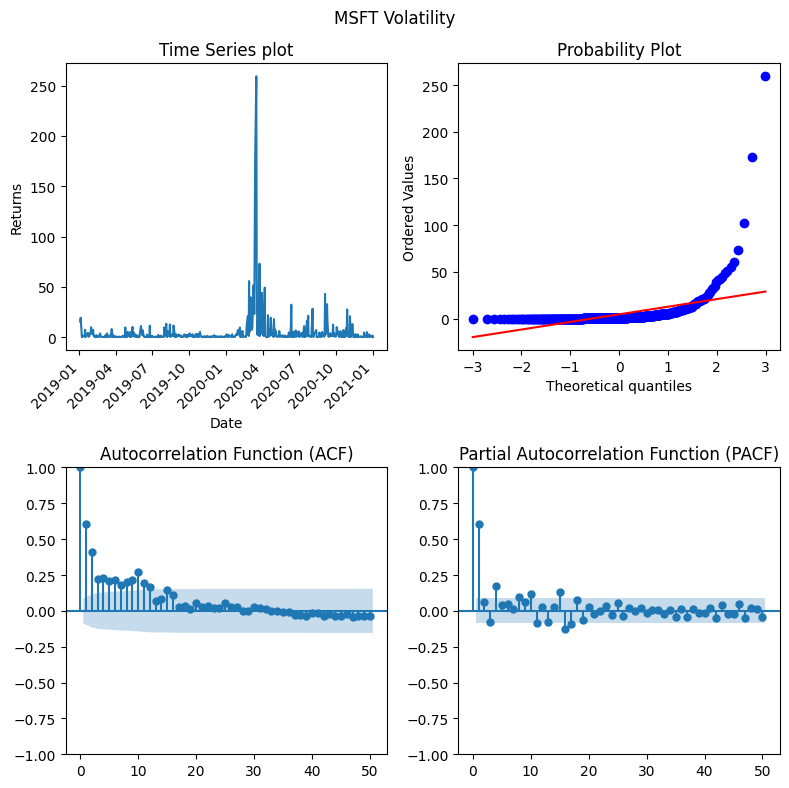

In [63]:
# calculate the volatility

stocks['sigma'] = stocks['Log_Return'].sub(stocks['Log_Return'].mean()).pow(2)

plot_stock_ts(stocks['sigma'], lags=50,title=f'{ticker} Volatility')

The volatility plot shows **volatility clustering** i.e. large changes tend is followed by large changes, of either sign, and small changes tend to be followed by small changes.

## GARCH(1,1) Models

GARCH(1,1) has only one parameter of each kind in it.
The equation has three constants: $\alpha$, $\beta$ and $\omega$. The $\omega$ parameter behaves like a con-
stant volatility you expect in a homoscedastic model while the $\alpha$ and $\beta$ parameters 
are a generalisation of the parameters in an exponentially weighted moving average model. 

The formula is:

$GARCH(1,1):\sigma_{t}^2=\omega+\alpha \epsilon^2_{t−1}+\beta \sigma^2_{t−1}$

Sometimes  the  constant  $\beta$  is  called  the  persistence 
because if it’s large, sharp rises in volatility take a long time to die down. The 
constant $\alpha$ is sometimes called the reaction because it determines how the volatility is affected by the latest return data.


In [64]:
basic_gm = arch_model(stocks['Return'], p = 1, q = 1,mean = 'constant', vol = 'GARCH', dist = 'normal')
# Fit the model
gm_result = basic_gm.fit(update_freq = 4)

Iteration:      4,   Func. Count:     30,   Neg. LLF: 959.7554697162682
Iteration:      8,   Func. Count:     52,   Neg. LLF: 957.491525242415
Optimization terminated successfully    (Exit mode 0)
            Current function value: 957.491525242415
            Iterations: 9
            Function evaluations: 56
            Gradient evaluations: 9


In [65]:
print(gm_result.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -957.492
Distribution:                  Normal   AIC:                           1922.98
Method:            Maximum Likelihood   BIC:                           1939.87
                                        No. Observations:                  504
Date:                Fri, Nov 10 2023   Df Residuals:                      503
Time:                        02:48:04   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1828  5.787e-02      3.158  1.588e-03 [6.935e-0

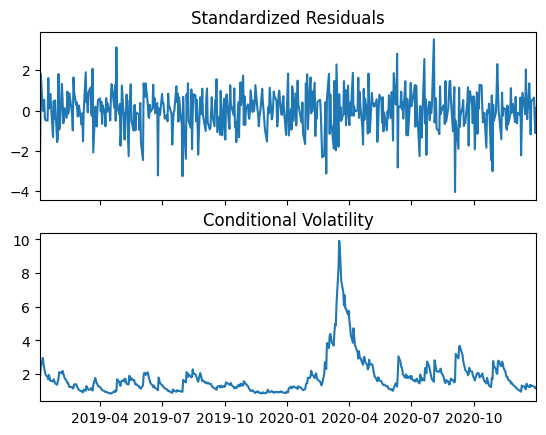

In [66]:
# Plot fitted results
gm_result.plot()
plt.show()

<Axes: xlabel='Date'>

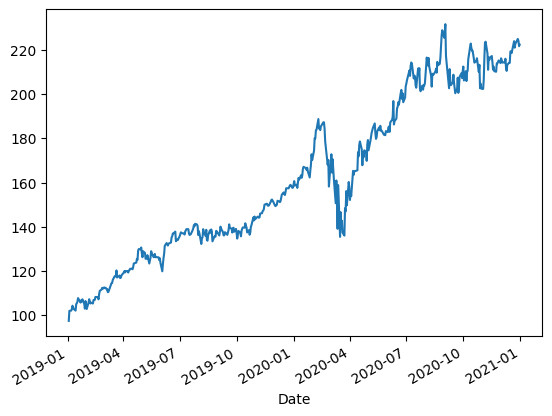

In [67]:
stocks.Close.plot()